In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics import mean_squared_error
import cartopy.mpl.gridliner as gridliner

In [2]:
# Reading the error data
train_errors_df=pd.read_hdf('train_errors.h5',header=0)
test_errors_df=pd.read_hdf('test_errors.h5',header=0)

In [ ]:
# Initialize a dictionary to store MSE for each index
mse_per_index = {}

# Get unique values of the first index level in multi-index
unique_first_indices = train_errors_df.index.get_level_values(0).unique()

# Iterate over each unique first index
for first_index in unique_first_indices:
    # Find all data points with that first index
    subset_indices = train_errors_df.index.get_level_values(0) == first_index

    # Extract these data points from train errors
    subset = train_errors_df[subset_indices]
    # y_subset = y_train[first_fold_indices][fold_subset_indices]

    # If subset is not empty, predict and calculate MSE
    if len(subset) > 0:
        mse = mean_squared_error(subset['y_train'], subset['y_train_pred'])
        mse_per_index[first_index] = mse

# Print MSE for each index
for index, mse in mse_per_index.items():
    print(f"MSE for first index {index}: {mse}")

In [4]:
# Convert the mse_per_index dictionary to a list
mse_list = list(mse_per_index.items())
# 将列表转换为 DataFrame
mse_df = pd.DataFrame(mse_list, columns=['Index', 'MSE'])

# Convert the list to a DataFrame and save as CSV
mse_df.to_csv('mse_training_station.csv', index=False)

# Sort the MSE list in descending order
mse_list.sort(key=lambda x: x[1], reverse=True)


In [ ]:
# Repeat the process for test errors
mse_per_index2 = {}
unique_first_indices = test_errors_df.index.get_level_values(0).unique()

for first_index in unique_first_indices:
    subset_indices = test_errors_df.index.get_level_values(0) == first_index
    subset = test_errors_df[subset_indices]
    if len(subset) > 0:
        mse = mean_squared_error(subset['y_test'], subset['y_test_pred'])
        mse_per_index2[first_index] = mse
for index, mse in mse_per_index2.items():
    print(f"MSE for first index {index}: {mse}")
mse_list2 = list(mse_per_index2.items())

mse_df2 = pd.DataFrame(mse_list2, columns=['Index', 'MSE'])


mse_df2.to_csv('mse_training_station.csv', index=False)

mse_list2.sort(key=lambda x: x[1], reverse=True)

In [3]:
# Read station data and merge with MSE data
stations_df = pd.read_csv('igs_stations_subset.csv')
mse_df = pd.read_csv('mse_training_station.csv')
mse_df.rename(columns={'Index': 'station'}, inplace=True)
merged_df = pd.merge(stations_df, mse_df, on='station')

# Extract coordinates and MSE values
lons = merged_df['Longitude'].values
lats = merged_df['Latitude'].values
mse_values = merged_df['MSE'].values

In [4]:
# Repeat the process for the second MSE dataset
mse_df2 = pd.read_csv('mse_test_station.csv')
mse_df2.rename(columns={'Index': 'station'}, inplace=True)
merged_df2 = pd.merge(stations_df, mse_df2, on='station')
lons2 = merged_df2['Longitude'].values
lats2 = merged_df2['Latitude'].values
mse_values2 = merged_df2['MSE'].values

In [5]:
# Calculate the square root of MSE values
rmse_values=np.sqrt(mse_values)
rmse_values2=np.sqrt(mse_values2)

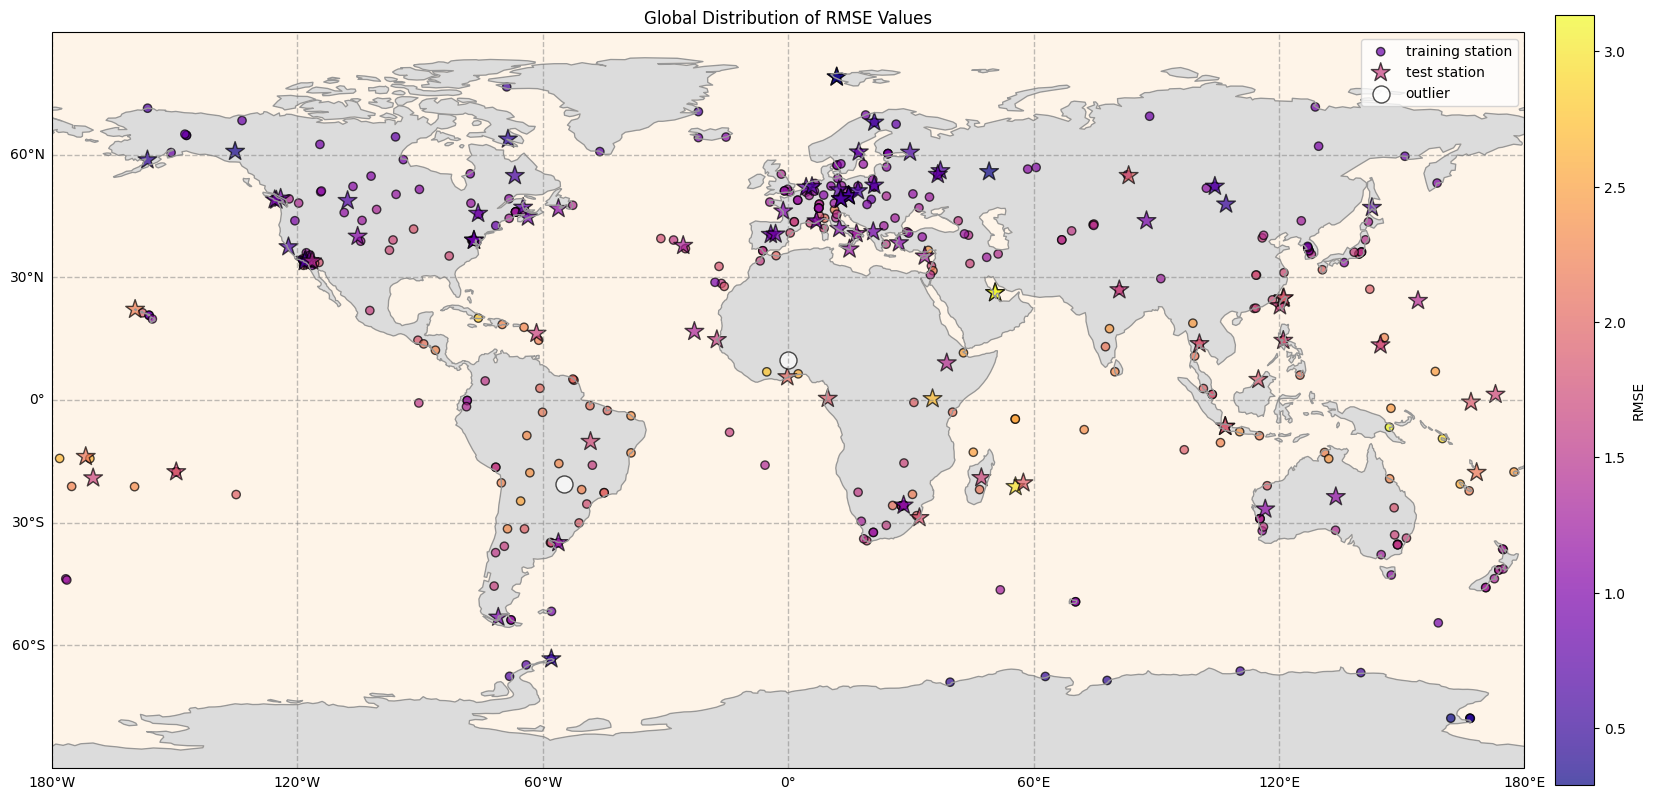

In [11]:
# Create a mask for MSE values greater than 5
mask = rmse_values > 5
mask2 = rmse_values2 > 5

# Create a map
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()

# Set colors for land and ocean
land_color = '#DCDCDC'  # LightGoldenrodYellow
ocean_color = '#FEF4E8' # LightGrey
ax.add_feature(cfeature.LAND, facecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color)

# Customize coastline color and thickness
coastline_color = '#979797'  
coastline_width = 1.0  
ax.coastlines(color=coastline_color, linewidth=coastline_width)

# Add and customize gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER


# Scatter plot for points with MSE <= 5
scatter = ax.scatter(lons[~mask], lats[~mask], c=rmse_values[~mask], cmap='plasma', alpha=0.7, edgecolors='k', label='training station', transform=ccrs.PlateCarree())
scatter_attr2 = ax.scatter(lons2[~mask2], lats2[~mask2], c=rmse_values2[~mask2], cmap='plasma', s=200,alpha=0.7, edgecolors='k', marker='*', label='test station', transform=ccrs.PlateCarree())


# Scatter plot for points with MSE > 5
scatter_white = ax.scatter(lons[mask], lats[mask], c='white', s=150, alpha=0.7, edgecolors='k', transform=ccrs.PlateCarree(),label='outlier')
scatter_white2 = ax.scatter(lons2[mask2], lats2[mask2], c='white', s=200, alpha=0.7, edgecolors='k',  marker='*', transform=ccrs.PlateCarree())


# Add color bar
plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, fraction=0.03, label='RMSE')

# Title
plt.title('Global Distribution of RMSE Values')

# Add legend
plt.legend(loc='upper right')

# Display map
plt.show()